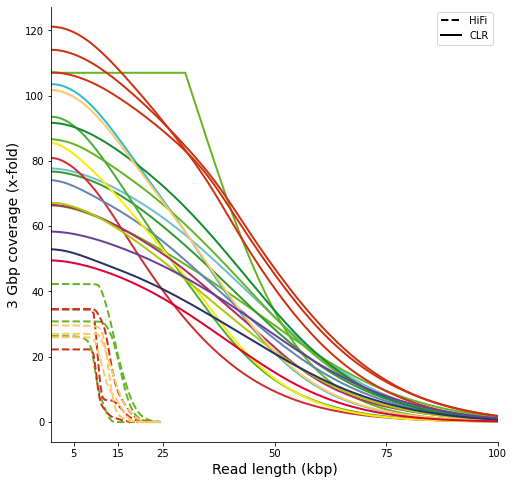

In [2]:
import os
import pickle
import importlib.util

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

stats_path = '/home/local/work/data/hgsvc/lr_stat_dumps'
out_path = os.path.join(stats_path, 'read_stats_panel.png')
cache_file = os.path.join(stats_path, 'cache.h5')

read_length_bounds = list(range(0, 100500, 500))


def load_sequenced_bases(file_path, summarize_read_length):
        
    with open(file_path, 'rb') as dump:
        data = pickle.load(dump)
    
    buffer_values = np.zeros(100001, dtype=np.int64)
    for read_length, abundance in data['len_stats'].items():
        if read_length >= 1e5:
            buffer_values[-1] += int(read_length * abundance)
        else:
            buffer_values[read_length] += int(read_length * abundance)

    plot_values = np.zeros(len(summarize_read_length), dtype=np.int64)
    for idx, mrl in enumerate(summarize_read_length):
        seq_bp = buffer_values[mrl:].sum()
        if seq_bp == 0:
            break
        plot_values[idx] = seq_bp
    return plot_values


if not os.path.isfile(cache_file):
    pickle_files = [os.path.join(stats_path, f) for f in os.listdir(stats_path) if f.endswith('.pck')]
    plot_data = [load_sequenced_bases(fp, read_length_bounds) for fp in pickle_files]

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in pickle_files]
    row_index = []
    for sample, platform in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform))
    df = pd.DataFrame(plot_data, columns=read_length_bounds, index=row_index)
    df.index = pd.MultiIndex.from_tuples(df.index.values, names=['sample', 'super_pop', 'pop', 'platform'])
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform'])


def plot_sequenced_bases_statistic(sample_stats):
    
    x_values = sample_stats.columns
    x_labels = [str(round(x/1000, 1)) for x in x_values]
    
    sample_stats /= 3*1e9
    sample_stats = sample_stats.round(2)

    fig, axis = plt.subplots(figsize=(8,8))
    
    for idx, values in sample_stats.iterrows():
        sample, super_pop, pop, platform = idx
        if 'HiFi' in idx:
            linestyle = 'dashed'
        else:
            linestyle = 'solid'
        color = rgbcodes[pop]
    
        x_limit = None
        if platform == 'HiFi':
            x_limit = 50
    
        axis.plot(
            x_values[:x_limit],
            values[:x_limit],
            color=color,
            label='{}/{}'.format(sample, platform),
            lw=2,
            ls=linestyle
        )

    plot_x_values = [5000, 15000, 25000, 50000, 75000, 100000]
    plot_x_labels = list(map(str, [int(x/1000) for x in plot_x_values]))
    
    axis.set_xlabel('Read length (kbp)', fontsize=14)
    axis.set_xticks(plot_x_values)
    axis.set_xticklabels(plot_x_labels)
    axis.set_xlim(0, 100000)
    
    axis.set_ylabel('3 Gbp coverage (x-fold)', fontsize=14)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_lines = [
        #lines.Line2D([0], [0], color=rgbcodes['AFR'], lw=4),
        #lines.Line2D([0], [0], color=rgbcodes['AMR'], lw=4),
        #lines.Line2D([0], [0], color=rgbcodes['EAS'], lw=4),
        #lines.Line2D([0], [0], color=rgbcodes['EUR'], lw=4),
        #lines.Line2D([0], [0], color=rgbcodes['SAS'], lw=4),
        #lines.Line2D([0], [0], color='white', lw=2),
        lines.Line2D([0], [0], color='black', ls='dashed', lw=2),
        lines.Line2D([0], [0], color='black', ls='solid', lw=2),
    ]
    
    axis.legend(
        custom_lines,
        ['HiFi', 'CLR']
    )
   
    return fig, []

fig, extra_artists = plot_sequenced_bases_statistic(df)

fig.savefig(out_path, dpi=600, bbox_inches='tight', extra_artists=extra_artists)
        
    